In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ***PREPARATION OF TRAINING DATA ( RESIZEING AND STORING INTO NUMPY ARRAY)***

In [6]:
import numpy as np
import os
import random
import cv2
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split


datapath='../input/covid19-radiography-database/COVID-19_Radiography_Dataset'
categories=['COVID','Lung_Opacity','Normal']

training_data=[]
#,cv2.IMREAD_GRAYSCALE
def create_training_data():
    with tf.device('/device:GPU:0'):
        for cat in categories:
            count=0;
            path=os.path.join(datapath,cat)
            class_num=categories.index(cat)
            for i in range(1000):
                try:
                    img = random.choice(os.listdir(path))
                    img_array=cv2.imread(os.path.join(path,img))
                    new=cv2.resize(img_array,(224,224))
                    training_data.append([new,class_num])
                except Exception as e:
                    pass

create_training_data()

random.shuffle(training_data)

X=[]
y=[]


for features,label in training_data:
    X.append(features)
    y.append(label)


X=np.array(X).reshape(-1,224,224,3)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2,random_state = 1)

X_test=X_test/255.0

print(X_train.shape)
print(X_test.shape)

pickle_out=open("Xtrain2.pickle","wb") 
pickle.dump(X_train,pickle_out)
pickle_out.close()

pickle_out=open("ytrain2.pickle","wb")
pickle.dump(y_train,pickle_out)
pickle_out.close()


(2400, 224, 224, 3)
(600, 224, 224, 3)


# **VGG16**

In [10]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Dropout,AveragePooling2D
import pickle
from keras.utils.np_utils import to_categorical


X=pickle.load(open("./Xtrain2.pickle","rb"))
y=pickle.load(open("./ytrain2.pickle","rb"))


X=X/255.0
y=to_categorical(y)

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

base_model=tf.keras.applications.VGG16(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)


base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.Dense(1024)(x)
#x=Dropout(0.5)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy",optimizer=opt , metrics=['accuracy'])

model.fit(X,y,batch_size=32,epochs=30,validation_split=0.2)
model.save("CovidDetector1")

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/30
60/60 [==============================] - 16s 97ms/step - loss: 1.1004 - accuracy: 0.3707 - val_loss: 1.0700 - val_accuracy: 0.3917
Epoch 2/30
60/60 [==============================] - 5s 85ms/step - loss: 1.0554 - accuracy: 0.4877 - val_loss: 1.0214 - val_accuracy: 0.6021
Epoch 3/30
60/60 [==============================] - 5s 85ms/step - loss: 1.0188 - accuracy: 0.5779 - val_loss: 0.9845 - val_accuracy: 0.6083
Epoch 4/30
60/60 [==============================] - 5s 85ms/step - loss: 0.9964 - accuracy: 0.5840 - val_loss: 0.9563 - val_accuracy: 0.5917
Epoch 5/30
60/60 [==============================] - 5s 85ms/step - loss: 0.9682 - accuracy: 0.6056 - val_loss: 0.9341 - val_accuracy: 0.5917
Epoch 6/30
60/60 [==============================] - 5s 84ms/step - loss: 0.9481 - accuracy: 0.6101 - val_loss: 0.9122 - val_accuracy: 0.6313
Epoch 7/30
60/60 [==============================] - 5s 86ms/step - loss: 0.9393 - accura

In [11]:
base_model.trainable = True
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy",optimizer=opt , metrics=['accuracy'])
model.fit(X,y,batch_size=32,epochs=30,validation_split=0.2)
model.save("CovidDetector2")

Epoch 1/30
60/60 [==============================] - 16s 233ms/step - loss: 0.7676 - accuracy: 0.6842 - val_loss: 0.5931 - val_accuracy: 0.7646
Epoch 2/30
60/60 [==============================] - 13s 224ms/step - loss: 0.5840 - accuracy: 0.7722 - val_loss: 0.4424 - val_accuracy: 0.8396
Epoch 3/30
60/60 [==============================] - 13s 225ms/step - loss: 0.4435 - accuracy: 0.8329 - val_loss: 0.3923 - val_accuracy: 0.8583
Epoch 4/30
60/60 [==============================] - 13s 223ms/step - loss: 0.4066 - accuracy: 0.8399 - val_loss: 0.4618 - val_accuracy: 0.8125
Epoch 5/30
60/60 [==============================] - 13s 225ms/step - loss: 0.4172 - accuracy: 0.8412 - val_loss: 0.3131 - val_accuracy: 0.9000
Epoch 6/30
60/60 [==============================] - 13s 224ms/step - loss: 0.2963 - accuracy: 0.8833 - val_loss: 0.3051 - val_accuracy: 0.9125
Epoch 7/30
60/60 [==============================] - 14s 225ms/step - loss: 0.2861 - accuracy: 0.8959 - val_loss: 0.3826 - val_accuracy: 0.8396

# **EVALUATION OF MODEL ON TEST DATA**

In [12]:
print(X_test.shape)
ytest1=to_categorical(y_test)
model.evaluate(X_test,ytest1)

(600, 224, 224, 3)
19/19 [==============================] - 4s 191ms/step - loss: 0.3532 - accuracy: 0.8900


[0.35322508215904236, 0.8899999856948853]

# ***CONFUSION MATRIX***

In [13]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

              precision    recall  f1-score   support

           0       0.90      0.98      0.93       204
           1       0.87      0.87      0.87       199
           2       0.90      0.82      0.86       197

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



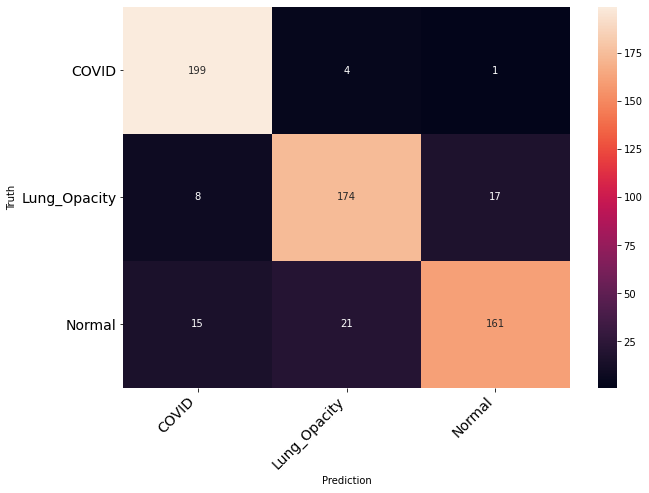

In [14]:
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

ypred = model.predict(X_test)
ypred=np.argmax(ypred,axis=1)
cm = confusion_matrix(y_test,ypred)
print_confusion_matrix(cm,['COVID','Lung_Opacity','Normal'])


print(classification_report(y_test,ypred))

# ***DENSENET MODEL***

In [15]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Dropout,AveragePooling2D
import pickle
from keras.utils.np_utils import to_categorical


X=pickle.load(open("Xtrain2.pickle","rb"))
y=pickle.load(open("ytrain2.pickle","rb"))


X=X/255.0
y=to_categorical(y)

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

base_model=tf.keras.applications.DenseNet121(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)


base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.Dense(1024)(x)
#x=Dropout(0.5)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy",optimizer=opt , metrics=['accuracy'])

model.fit(X,y,batch_size=32,epochs=30,validation_split=0.2)
model.save("CovidDetector1")

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/30
60/60 [==============================] - 13s 115ms/step - loss: 1.0760 - accuracy: 0.4182 - val_loss: 0.8985 - val_accuracy: 0.5938
Epoch 2/30
60/60 [==============================] - 4s 74ms/step - loss: 0.8706 - accuracy: 0.6407 - val_loss: 0.7895 - val_accuracy: 0.6833
Epoch 3/30
60/60 [==============================] - 4s 75ms/step - loss: 0.7660 - accuracy: 0.7075 - val_loss: 0.7273 - val_accuracy: 0.7063
Epoch 4/30
60/60 [==============================] - 5s 76ms/step - loss: 0.7321 - accuracy: 0.7055 - val_loss: 0.6889 - val_accuracy: 0.7312
Epoch 5/30
60/60 [==============================] - 4s 75ms/step - loss: 0.6948 - accuracy: 0.7336 - val_loss: 0.6771 - val_accuracy: 0.7167
Epoch 6/30
60/60 [==============================] - 5s 77ms/step - loss: 0.6474 - accuracy: 0.7496 - val_loss: 0.6556 - val_accuracy: 0.7104
Epoch 7/30
60/60 [==============================] - 4s 73ms/step - loss: 0.6367 - accur

In [16]:
base_model.trainable = True
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy",optimizer=opt , metrics=['accuracy'])
model.fit(X,y,batch_size=32,epochs=30,validation_split=0.2)
model.save("CovidDetector2")

Epoch 1/30
60/60 [==============================] - 28s 278ms/step - loss: 0.5137 - accuracy: 0.7991 - val_loss: 0.4490 - val_accuracy: 0.8104
Epoch 2/30
60/60 [==============================] - 14s 236ms/step - loss: 0.4112 - accuracy: 0.8378 - val_loss: 0.4368 - val_accuracy: 0.8333
Epoch 3/30
60/60 [==============================] - 14s 236ms/step - loss: 0.4187 - accuracy: 0.8305 - val_loss: 0.3928 - val_accuracy: 0.8354
Epoch 4/30
60/60 [==============================] - 14s 236ms/step - loss: 0.3695 - accuracy: 0.8523 - val_loss: 0.4162 - val_accuracy: 0.8458
Epoch 5/30
60/60 [==============================] - 14s 236ms/step - loss: 0.3059 - accuracy: 0.8799 - val_loss: 0.3964 - val_accuracy: 0.8396
Epoch 6/30
60/60 [==============================] - 14s 236ms/step - loss: 0.2987 - accuracy: 0.8853 - val_loss: 0.4207 - val_accuracy: 0.8438
Epoch 7/30
60/60 [==============================] - 14s 236ms/step - loss: 0.2715 - accuracy: 0.8931 - val_loss: 0.3664 - val_accuracy: 0.8521

# ***EVALUATION OF MODEL ON TEST DATA***

In [17]:
print(X_test.shape)
ytest1=to_categorical(y_test)
model.evaluate(X_test,ytest1)

(600, 224, 224, 3)
19/19 [==============================] - 4s 82ms/step - loss: 0.3299 - accuracy: 0.8917


[0.32990583777427673, 0.8916666507720947]

# ***CONFUSION MATRIX AND MODEL MATRICES***

In [18]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       204
           1       0.90      0.84      0.87       199
           2       0.90      0.87      0.88       197

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



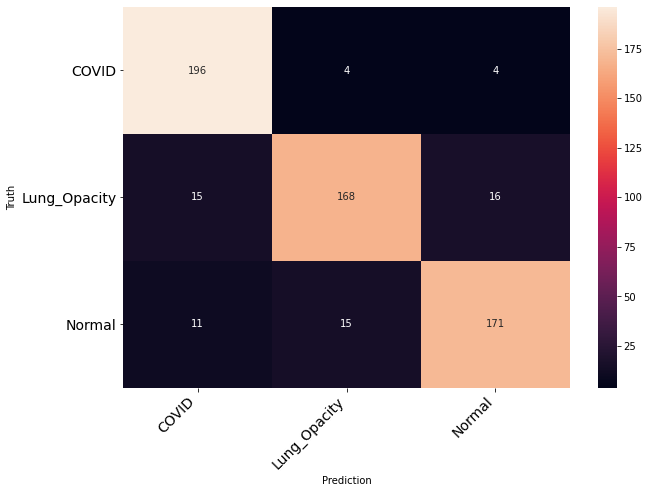

In [19]:
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

ypred = model.predict(X_test)
ypred=np.argmax(ypred,axis=1)
cm = confusion_matrix(y_test,ypred)
print_confusion_matrix(cm,['COVID','Lung_Opacity','Normal'])


print(classification_report(y_test,ypred))

# **MOBILENETV2**

In [20]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Dropout,AveragePooling2D
import pickle
from keras.utils.np_utils import to_categorical


X=pickle.load(open("Xtrain2.pickle","rb"))
y=pickle.load(open("ytrain2.pickle","rb"))


X=X/255.0
y=to_categorical(y)

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

base_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.Dense(1024)(x)
#x=Dropout(0.5)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy",optimizer=opt , metrics=['accuracy'])

model.fit(X,y,batch_size=32,epochs=30,validation_split=0.2)
model.save("CovidDetector2")

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/30
60/60 [==============================] - 6s 58ms/step - loss: 1.0183 - accuracy: 0.4888 - val_loss: 0.8127 - val_accuracy: 0.6375
Epoch 2/30
60/60 [==============================] - 2s 40ms/step - loss: 0.7533 - accuracy: 0.6786 - val_loss: 0.7201 - val_accuracy: 0.6958
Epoch 3/30
60/60 [==============================] - 2s 40ms/step - loss: 0.6653 - accuracy: 0.7361 - val_loss: 0.6985 - val_accuracy: 0.7042
Epoch 4/30
60/60 [==============================] - 2s 42ms/step - loss: 0.6226 - accuracy: 0.7607 - val_loss: 0.6877 - val_accuracy: 0.7208
Epoch 5/30
60/60 [==============================] - 2s 41ms/step - loss: 0.6135 - accuracy: 0.7504 - val_loss: 0.6460 - val_accuracy: 0.7375
Epoch 6/30
60/60 [==============================] - 2s 42ms/step - loss: 0.5795 - accuracy: 0.7652 - val_loss: 0.6373 - val_accuracy: 0.7333
Epoch 7/30
60/60 [==============================] - 2s 40ms/step - loss: 0.5849 - accuracy:

In [21]:
base_model.trainable = True
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy",optimizer=opt , metrics=['accuracy'])
model.fit(X,y,batch_size=32,epochs=30,validation_split=0.2)
model.save("CovidDetector2")

Epoch 1/30
60/60 [==============================] - 17s 202ms/step - loss: 0.4371 - accuracy: 0.8263 - val_loss: 0.4889 - val_accuracy: 0.7979
Epoch 2/30
60/60 [==============================] - 11s 184ms/step - loss: 0.3749 - accuracy: 0.8616 - val_loss: 0.4340 - val_accuracy: 0.8479
Epoch 3/30
60/60 [==============================] - 11s 186ms/step - loss: 0.3606 - accuracy: 0.8587 - val_loss: 0.4574 - val_accuracy: 0.8125
Epoch 4/30
60/60 [==============================] - 11s 186ms/step - loss: 0.3255 - accuracy: 0.8744 - val_loss: 0.3902 - val_accuracy: 0.8458
Epoch 5/30
60/60 [==============================] - 11s 183ms/step - loss: 0.2993 - accuracy: 0.8892 - val_loss: 0.4204 - val_accuracy: 0.8375
Epoch 6/30
60/60 [==============================] - 11s 184ms/step - loss: 0.3061 - accuracy: 0.8814 - val_loss: 0.3794 - val_accuracy: 0.8500
Epoch 7/30
60/60 [==============================] - 11s 184ms/step - loss: 0.2319 - accuracy: 0.9085 - val_loss: 0.3519 - val_accuracy: 0.8625

# ***EVALUATION OF MODEL ON TEST DATA***

In [22]:
print(X_test.shape)
ytest1=to_categorical(y_test)
model.evaluate(X_test,ytest1)

(600, 224, 224, 3)
19/19 [==============================] - 2s 36ms/step - loss: 0.3633 - accuracy: 0.8800


[0.3632592260837555, 0.8799999952316284]

# ***CONFUSION MATRIX AND MODEL MATRICES***

In [23]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       204
           1       0.84      0.87      0.86       199
           2       0.84      0.86      0.85       197

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



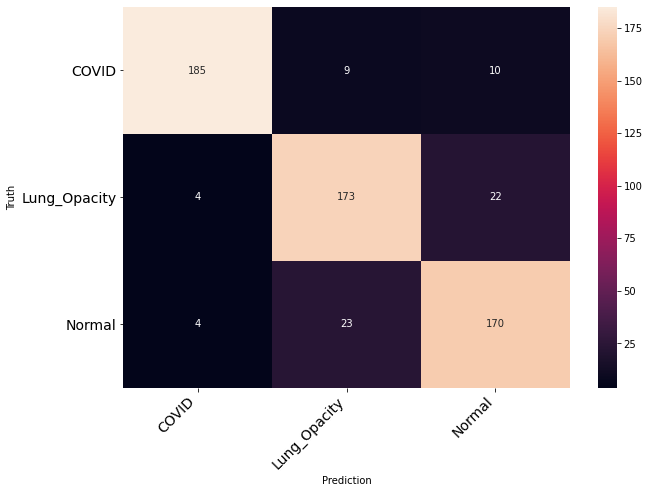

In [24]:

from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

ypred = model.predict(X_test)
ypred=np.argmax(ypred,axis=1)
cm = confusion_matrix(y_test,ypred)
print_confusion_matrix(cm,['COVID','Lung_Opacity','Normal'])


print(classification_report(y_test,ypred))

# ***# COMPARISON***

In [26]:
from tabulate import tabulate
print(tabulate([['VGG16', 89,89,89,89], ['DENSENET', 89,89,89,89.17],['MOBILENETV2', 88,88,88,88]], headers=['MODEL', 'PRECISION','RECALL','F1-SCORE','ACCURACY']))

MODEL          PRECISION    RECALL    F1-SCORE    ACCURACY
-----------  -----------  --------  ----------  ----------
VGG16                 89        89          89       89
DENSENET              89        89          89       89.17
MOBILENETV2           88        88          88       88
